In [25]:
from pandas_datareader import data
import numpy as np 
import scipy as sp 
import pandas as pd 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.notebook_repr_html', True)

from datetime import date, datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})  

from cryptocompare import get_daily_trades
from indicators import *

import requests
import talib
import plot

In [70]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2016-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
#prices = data.DataReader('TSLA', 'quandl', start_date, end_date,)
prices = get_daily_trades('ETH')
prices = prices.rename(columns={c: c.capitalize() for c in prices.columns})

In [71]:
prices.tail()

,Close,High,Low,Open,Volumefrom,Volumeto
time,,,,,,
2018-09-02,295.02,299.45,289.26,295.36,265838.74,7.827764e+07
2018-09-03,288.97,296.18,285.86,295.02,267190.84,7.740939e+07
2018-09-04,285.23,292.35,277.84,288.97,377762.81,1.082265e+08
2018-09-05,228.27,287.54,226.12,285.23,1098914.67,2.795995e+08
2018-09-06,226.47,232.78,211.18,228.27,1116412.01,2.507295e+08


In [72]:
#prices = prices.drop(prices[prices.High>1].index)

In [73]:
prices['prev_ath'] = prices.apply(lambda d: prices[:d.name].High.max(), axis=1)
prices['cycle_bottom'] = prices.apply(lambda d: prices[prices[prices.prev_ath==d.prev_ath].index[0]:d.name].Low.min(), axis=1)
prices['time_since_ath'] = prices.apply(lambda d: (d.name - prices[prices.prev_ath==d.prev_ath].index[0]).days , axis=1)
prices['time_since_bottom'] = prices.apply(lambda d: (d.name - prices[prices.cycle_bottom==d.cycle_bottom].index[0]).days , axis=1)

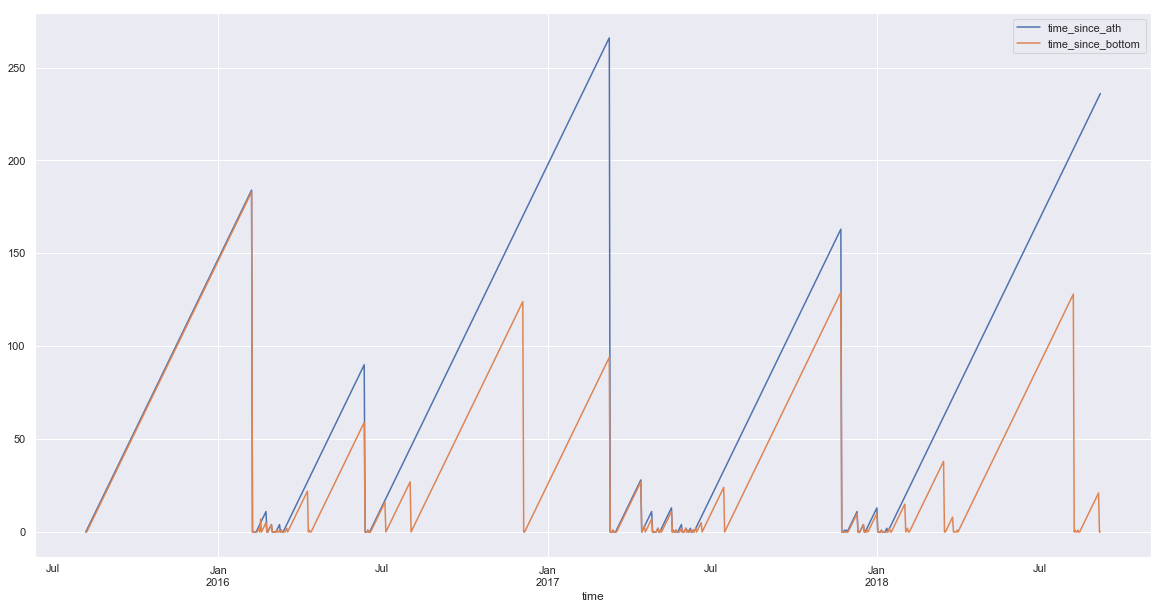

In [74]:
prices[['time_since_ath','time_since_bottom']].plot()

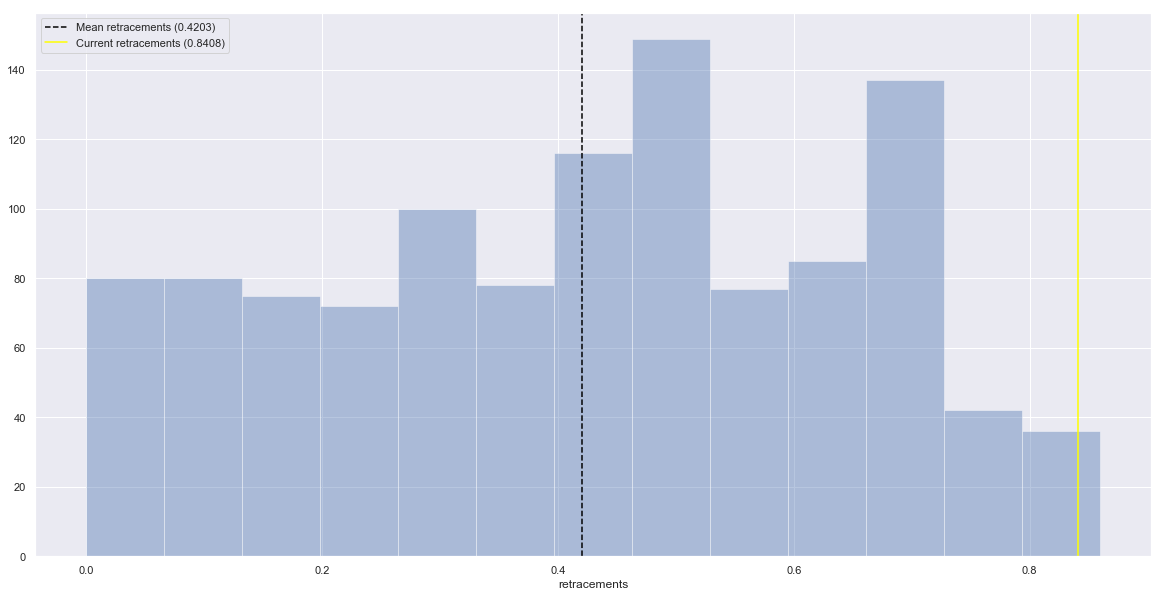

In [75]:
prices['retracements'] = prices.apply(lambda d: (d.prev_ath - d.Close)/d.prev_ath, axis=1)
plot.hist(prices.retracements, plot_last=True)

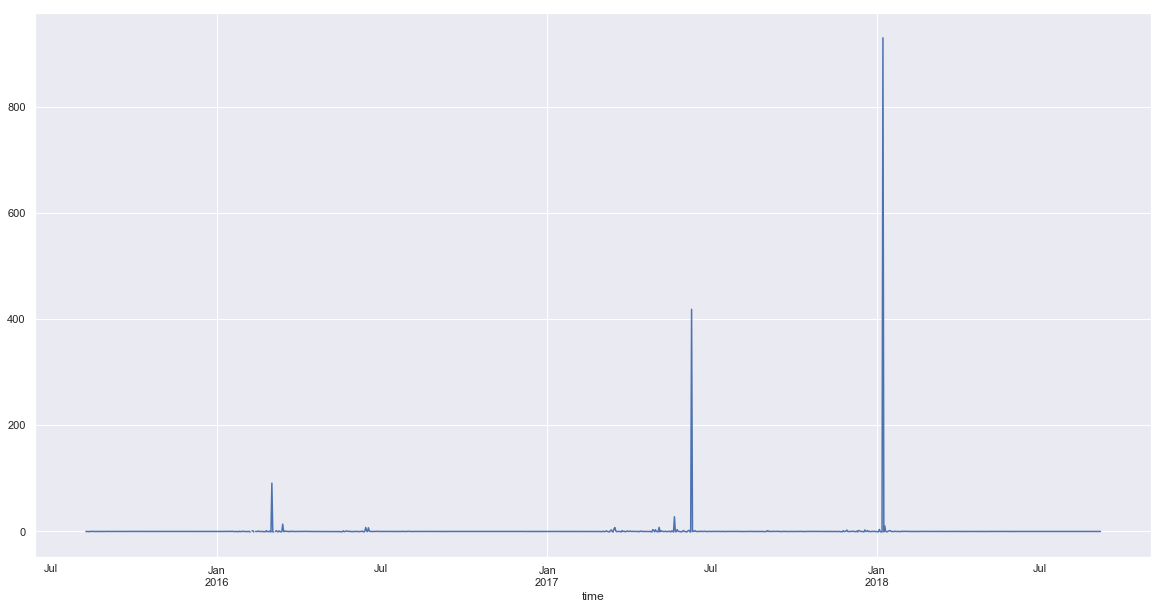

In [76]:
prices.retracements.pct_change(1).plot()

In [77]:
start = datetime(2017,6,1)
end = None#datetime(2013,7,1)
period = prices[start:end]

In [78]:
aths = period[period.prev_ath.diff(2)==0].prev_ath.value_counts().to_frame().reset_index().rename(columns={'index':'price','prev_ath':'days'})
aths.index = [period[period.prev_ath==a].sort_index().index[0] for a in aths.price]
aths = aths.sort_index()
aths['next_ath_date'] = aths.reset_index().shift(-1)['index'].values
premium = 1
aths['retested'] = aths.apply(lambda a: 
    period[a.next_ath_date:][period[a.next_ath_date:].Low <= a.price*premium].index[0] if any(period[a.next_ath_date:].Low <= a.price*premium) else None, axis=1)
pct_retested = round((~aths.retested.isnull()).sum()/aths.shape[0],4)*100
print('{}% of all time highs retested'.format(pct_retested)) 

100.0% of all time highs retested


In [79]:
aths

,price,days,next_ath_date,retested
2017-06-01,235.52,1,2017-06-06,2017-06-21
2017-06-06,268.12,1,2017-06-12,2017-06-15
2017-06-12,417.21,162,2017-11-29,2017-11-29
2017-11-29,515.44,10,2017-12-13,2017-12-22
2017-12-13,755.07,3,2017-12-19,2017-12-20
2017-12-19,868.89,12,2018-01-10,2018-01-16
2018-01-10,1385.22,1,2018-01-13,2018-01-13
2018-01-13,1422.86,235,NaT,2017-06-01


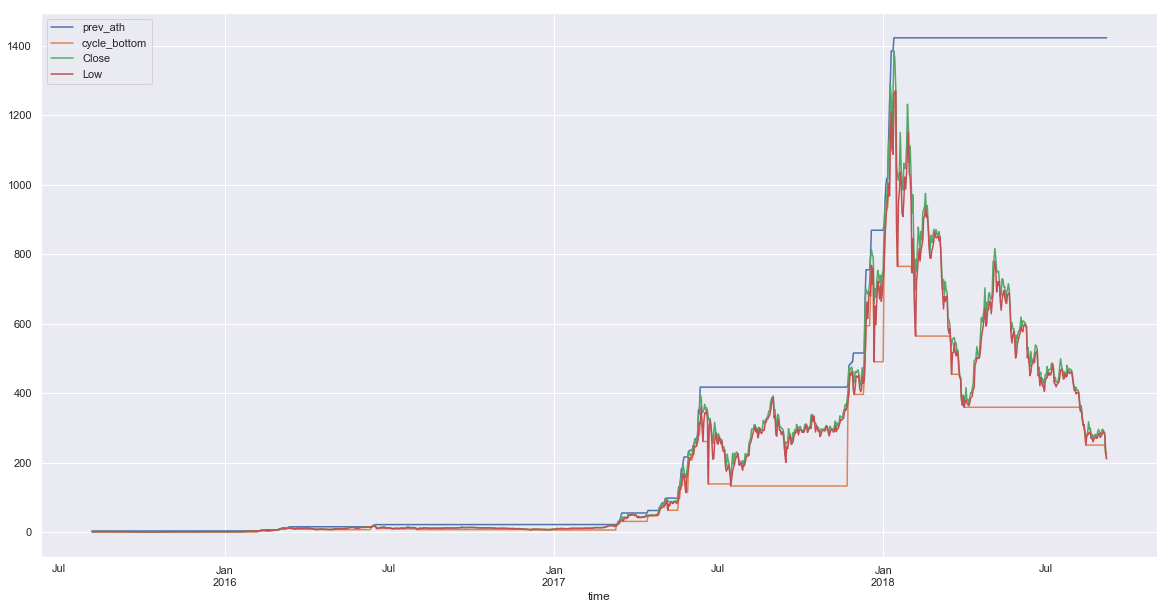

In [80]:
prices[['prev_ath','cycle_bottom', 'Close','Low']].plot()

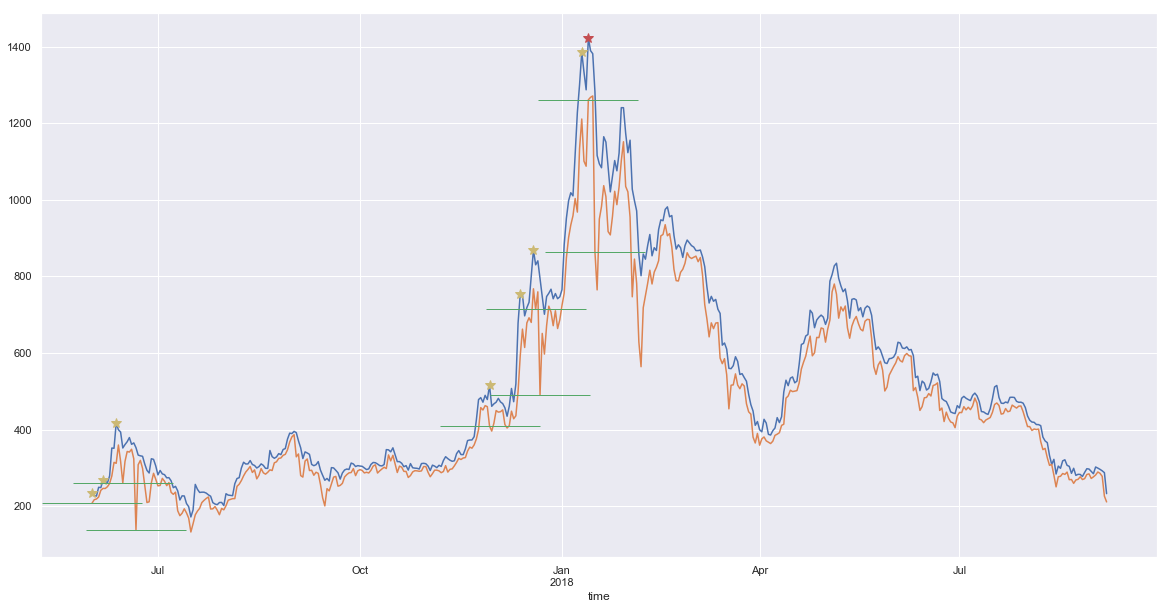

In [81]:
period.High.plot()
period.Low.plot()
period.loc[aths[(~aths.retested.isnull())&(~aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='y')
period.loc[aths[(aths.retested.isnull())|(aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='r')
period.loc[aths.retested.dropna()].Low.plot(marker='_', ls='', markersize=100)


In [82]:
period['RSI'] = talib.RSI(period.Close, timeperiod=7)
period['STOCH1'], period['STOCH2'] = talib.STOCH(period.High, period.Low, period.Close)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x109d93b00>,
      dtype=object)

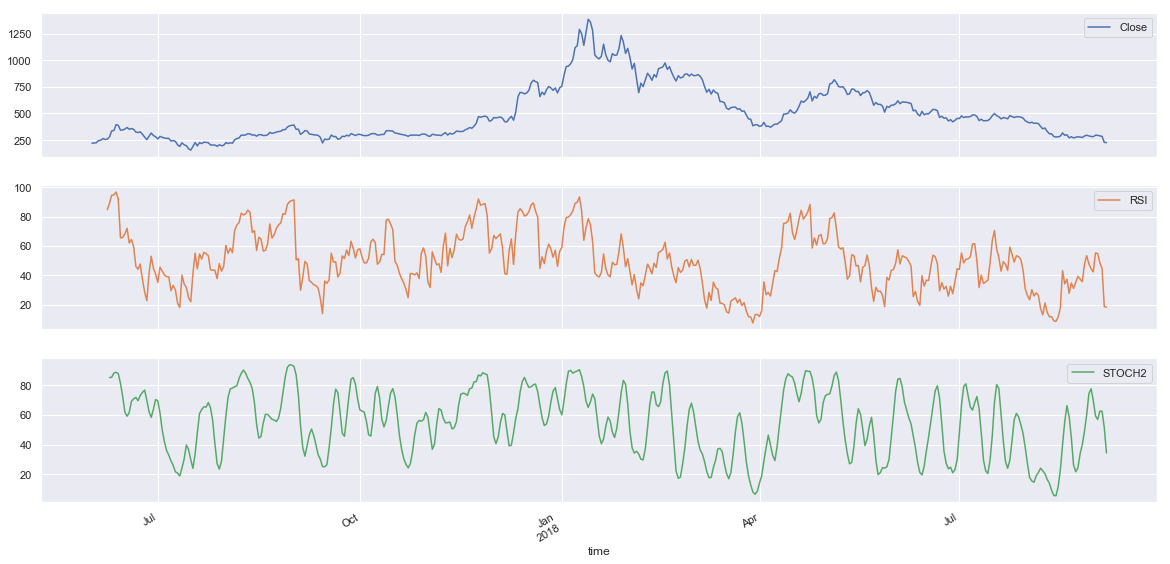

In [83]:
period[['Close','RSI','STOCH2']].plot(subplots=True)

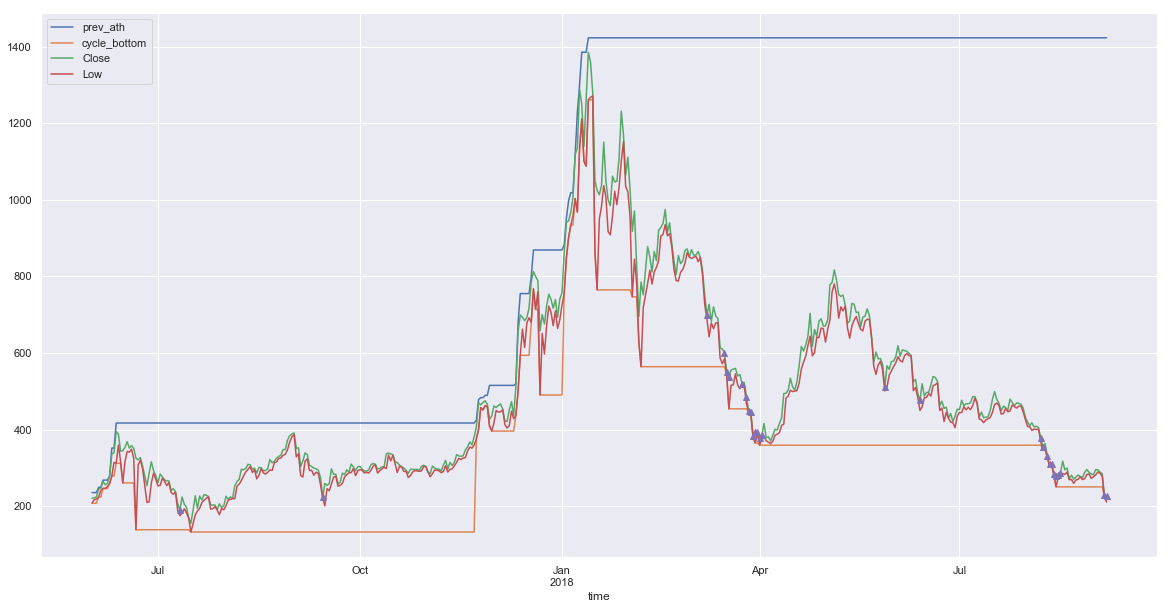

In [84]:
period[['prev_ath','cycle_bottom', 'Close','Low']].plot()
period[period.RSI <= 20].Close.plot(marker='^', ls='')

In [85]:
aths

,price,days,next_ath_date,retested
2017-06-01,235.52,1,2017-06-06,2017-06-21
2017-06-06,268.12,1,2017-06-12,2017-06-15
2017-06-12,417.21,162,2017-11-29,2017-11-29
2017-11-29,515.44,10,2017-12-13,2017-12-22
2017-12-13,755.07,3,2017-12-19,2017-12-20
2017-12-19,868.89,12,2018-01-10,2018-01-16
2018-01-10,1385.22,1,2018-01-13,2018-01-13
2018-01-13,1422.86,235,NaT,2017-06-01


In [86]:
bottoms = period[period.cycle_bottom.diff(2)==0].cycle_bottom.value_counts().to_frame().reset_index().rename(columns={'index':'price','cycle_bottom':'days'})
bottoms.index = [period[period.cycle_bottom==b].sort_index().index[0] for b in bottoms.price]
bottoms = bottoms.sort_index()
bottoms['next_bottom_date'] = bottoms.reset_index().shift(-1)['index'].values
discount = .95
bottoms['retested'] = bottoms.apply(lambda b:
    period[b.next_bottom_date:][period[b.next_bottom_date:].High >= b.price*discount].index[0] if any(period[b.next_bottom_date:].High >= b.price*discount) else None, axis=1)
pct_retested = round((~bottoms.retested.isnull()).sum()/bottoms.shape[0], 4)*100
print('{}% of cycle bottoms retested'.format(pct_retested))

"""

aths['next_ath_date'] = aths.reset_index().shift(-1)['index'].values
premium = 1
aths['retested'] = aths.apply(lambda a: 
    period[a.next_ath_date:][period[a.next_ath_date:].Low <= a.price*premium].index[0] if any(period[a.next_ath_date:].Low <= a.price*premium) else None, axis=1)
pct_retested = round((~aths.retested.isnull()).sum()/aths.shape[0],4)*100
print('{}% of all time highs retested'.format(pct_retested)) 
"""

93.33% of cycle bottoms retested


"\n\naths['next_ath_date'] = aths.reset_index().shift(-1)['index'].values\npremium = 1\naths['retested'] = aths.apply(lambda a: \n    period[a.next_ath_date:][period[a.next_ath_date:].Low <= a.price*premium].index[0] if any(period[a.next_ath_date:].Low <= a.price*premium) else None, axis=1)\npct_retested = round((~aths.retested.isnull()).sum()/aths.shape[0],4)*100\nprint('{}% of all time highs retested'.format(pct_retested)) \n"

In [87]:
bottoms

,price,days,next_bottom_date,retested
2017-06-01,208.00,1,2017-06-12,2017-06-12
2017-06-12,311.99,1,2017-06-15,2017-06-15
2017-06-15,260.78,4,2017-06-21,2017-06-21
2017-06-21,138.50,23,2017-07-16,2017-07-16
2017-07-16,132.64,128,2017-11-30,2017-11-30
2017-11-30,396.14,9,2017-12-13,2017-12-13
2017-12-13,593.89,3,2017-12-22,2017-12-22
2017-12-22,490.28,9,2018-01-13,2018-01-13
2018-01-13,1261.01,1,2018-01-17,2018-01-28
2018-01-17,764.75,14,2018-02-02,2018-02-02


In [88]:
bottoms.index[-2]

Timestamp('2018-04-01 00:00:00')

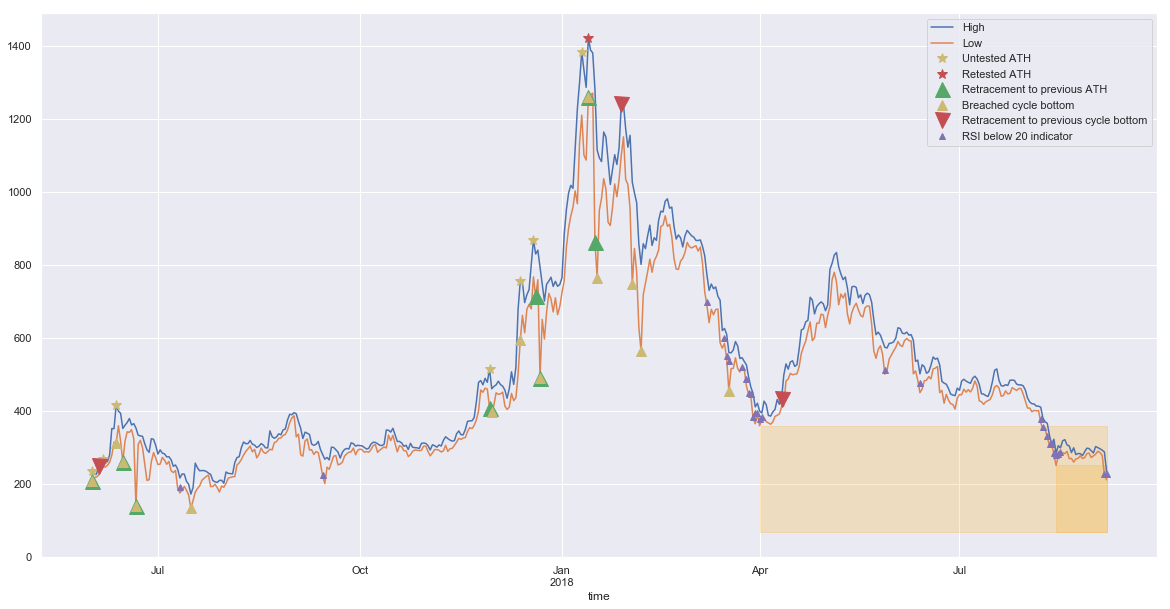

In [89]:
ax=period.High.plot()
period.Low.plot()
period.loc[aths[(~aths.retested.isnull())&(~aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='y', label='Untested ATH')
period.loc[aths[(aths.retested.isnull())|(aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='r', label='Retested ATH')
period.loc[aths.retested.dropna()].Low.plot(marker='^', ls='', markersize=15, label='Retracement to previous ATH')
period.loc[bottoms[(~bottoms.retested.isnull())&(~bottoms.next_bottom_date.isnull())].index].Low.plot(marker='^', ls='', markersize=10, color='y', label='Breached cycle bottom')

ymin, ymax = ax.get_ybound()
# cycle bottom that has yet to be retested 
cb_to_retest = period.loc[bottoms[(bottoms.retested.isnull())|(bottoms.next_bottom_date.isnull())].index]
for time, p in cb_to_retest.iterrows():#.plot(marker='s', ls='', markersize=10, color='r')
    ax.fill_between(period[time:].index, ymin, p.Low, alpha=0.2, color='orange')
period.loc[bottoms[bottoms.retested!=bottoms.next_bottom_date].retested.dropna()].High.plot(marker='v', ls='', markersize=15, label='Retracement to previous cycle bottom')
period[period.RSI <= 20].Close.plot(marker='^', ls='', label='RSI below 20 indicator')
ax.legend()


In [90]:
period['upper_bound'] = period.High.rolling(21).quantile(.90)
period['lower_bound'] = period.Low.rolling(21).quantile(.1)

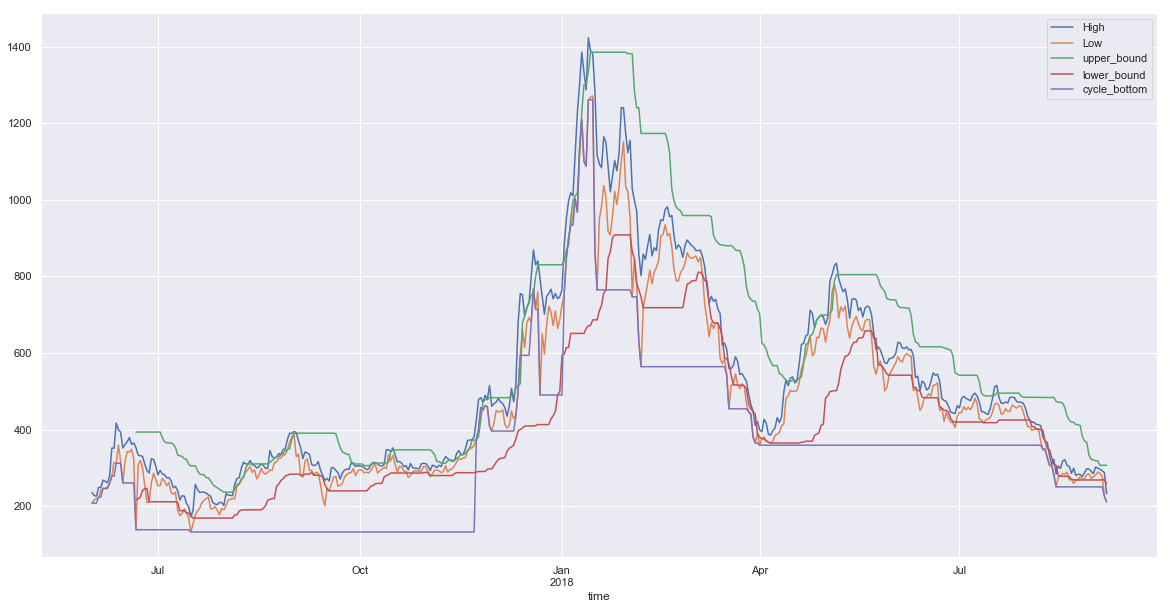

In [91]:
period[['High','Low','upper_bound','lower_bound','cycle_bottom']].plot()

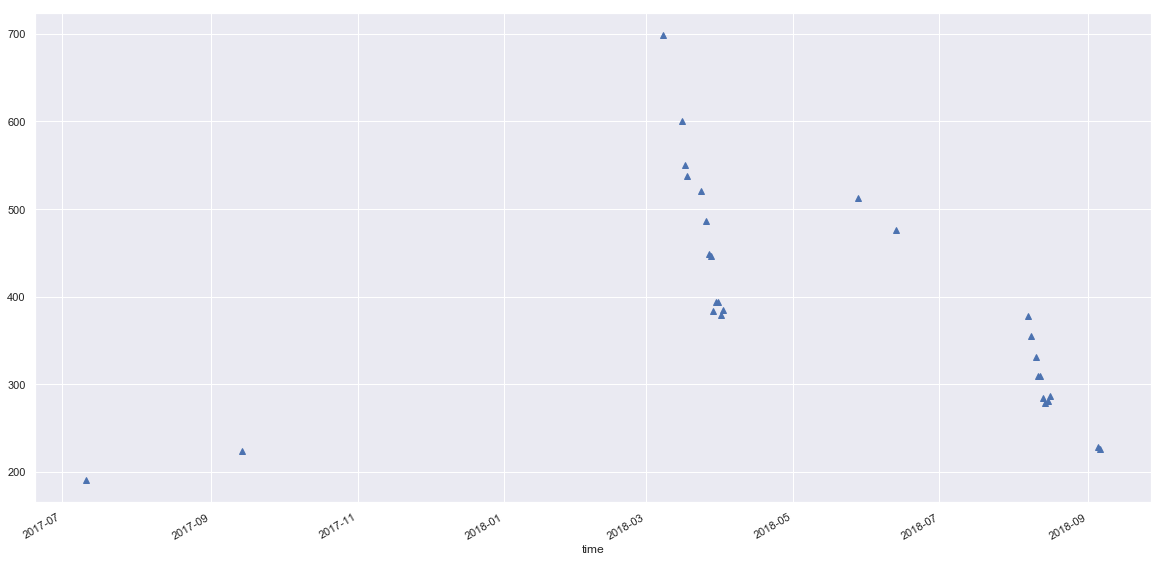

In [92]:
period[period.RSI <= 20].Close.plot(marker='^', ls='')

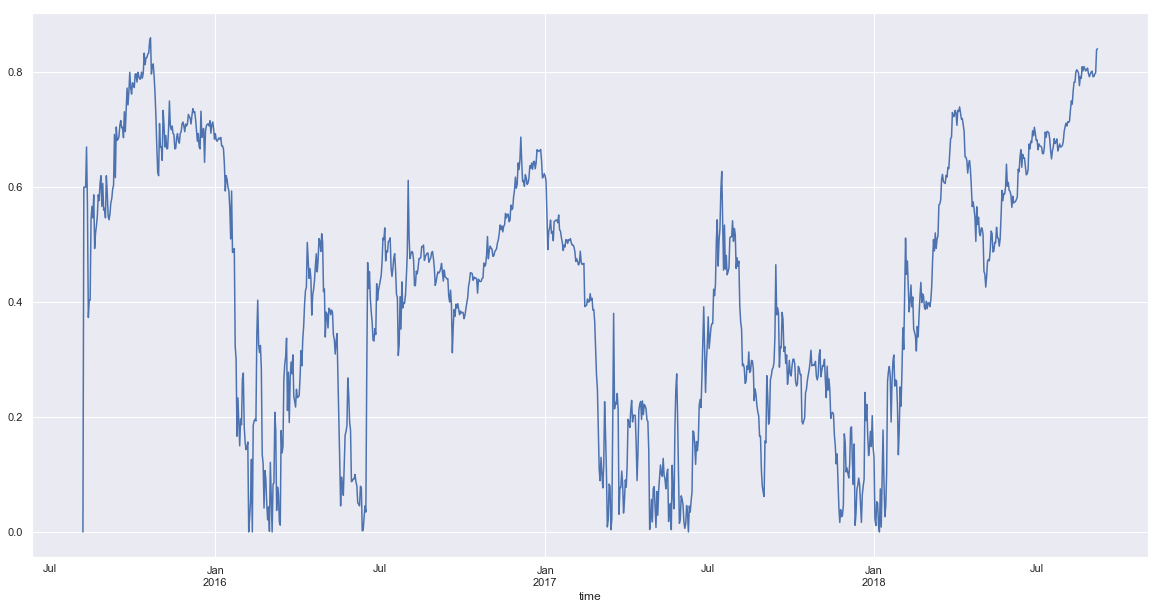

In [94]:
prices.retracements.plot()

In [93]:
df[datetime(2018,1,1)].close.pct_change(7)

NameError: name 'df' is not defined

In [ ]:
when playing a bounce you don't have a taget price you just have a time period to offload initial capital 
